## VCB

In [1]:
 # Chạy thư viện
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


 # Tải VCB dataset
stock_dataset = pd.read_csv('../../Dataset/VCB.csv')
display(stock_dataset)


# Chọn cột Close
data = stock_dataset[['Date','Close']]
data.rename(columns={'Close': 'Close Price'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date',inplace=True)
data.set_index('Date',inplace=True)
y = data['Close Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu trong khoản từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)


# Chia khoảng Train - Test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]


# Khởi tạo Timesteps
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(n_forecast))
# Chạy tới adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_test, Y_test),verbose=1)


# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))


# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-05,15582.061523,15778.680664,15434.597656,15680.371094,15680.371094,630678
1,2015-01-06,15680.371094,16712.621094,15680.371094,16712.621094,16712.621094,3427132
2,2015-01-07,16761.775391,17007.550781,16270.228516,16516.001953,16516.001953,3182476
3,2015-01-08,16565.156250,17204.169922,16516.001953,17007.550781,17007.550781,2043014
4,2015-01-09,17155.013672,18187.263672,17155.013672,18138.109375,18138.109375,5155103
...,...,...,...,...,...,...,...
2334,2024-05-27,90400.000000,90600.000000,89700.000000,90200.000000,90200.000000,1258620
2335,2024-05-28,89800.000000,90700.000000,89800.000000,90700.000000,90700.000000,1814349
2336,2024-05-29,90800.000000,91000.000000,89800.000000,89800.000000,89800.000000,1186438
2337,2024-05-30,89500.000000,89700.000000,88500.000000,88600.000000,88600.000000,2400732


C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\509019547.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Close': 'Close Price'}, inplace=True)
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\509019547.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\509019547.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0337 - val_loss: 9.3069e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 2.8202e-04 - val_loss: 4.4506e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 2.0575e-04 - val_loss: 4.0406e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 2.1488e-04 - val_loss: 3.7864e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 2.1246e-04 - val_loss: 3.6969e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 1.7479e-04 - val_loss: 3.4268e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 1.8752e-04 - val_loss: 3.3065e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.5747e-04 - val_loss: 3.4453e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 1.7196e-04 - val_loss: 3.3252e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.4061e-04 - val_loss: 3.7430e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 

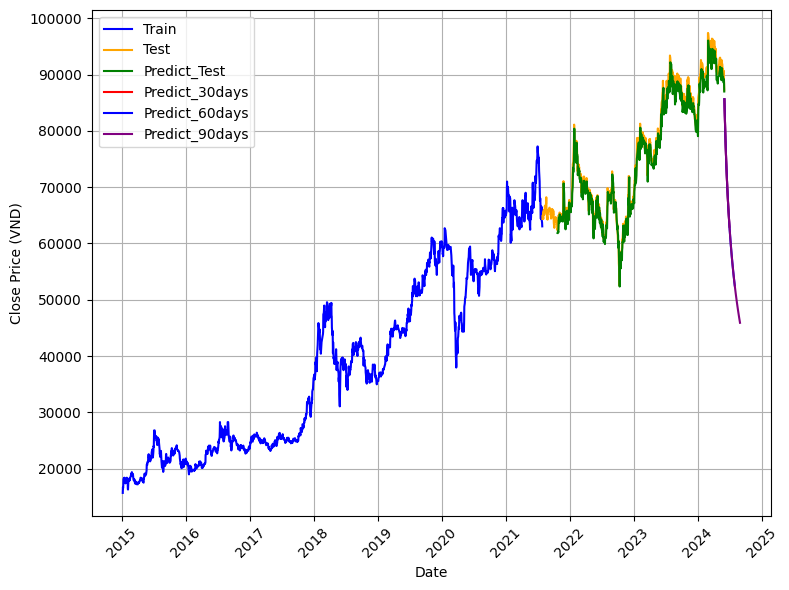

In [2]:
# Trực quan hóa
plt.figure(figsize=(8, 6))

# Vẽ tất cả các giá thực tế
plt.plot(data.index[:train_size], data['Close Price'][:train_size], label='Train', color='blue')

plt.plot(data.index[train_size:], data['Close Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập test
test_data_start = data.index[train_size + n_lookback]
test_data_end = data.index[-1]
plt.plot(data.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')


plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_data = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_data.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Forecast VCB stock prices in the next 90 days:")
print(future_data)

Forecast VCB stock prices in the next 90 days:
                Forecast
Date                    
2024-06-01  85631.679688
2024-06-02  84282.523438
2024-06-03  83063.968750
2024-06-04  81884.914062
2024-06-05  80718.140625
...                  ...
2024-08-25  46663.500000
2024-08-26  46471.082031
2024-08-27  46280.667969
2024-08-28  46092.214844
2024-08-29  45905.683594

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1576.8125970402025
MAPE: 1.621786669675862 %
MAE: 1256.5001338590334


##CTG

In [5]:
# Chạy thư viện
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


 # Tải VCB dataset
stock_dataset = pd.read_csv('../../Dataset/CTG.csv')
display(stock_dataset)


# Chọn cột Close
data = stock_dataset[['Date','Close']]
data.rename(columns={'Close': 'Close Price'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date',inplace=True)
data.set_index('Date',inplace=True)
y = data['Close Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu trong khoản từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)


# Chia khoảng Train - Test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]


# Khởi tạo Timesteps
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(n_forecast))
# Chạy tới adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_test, Y_test),verbose=1)


# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))


# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-05,9568.436523,9707.109375,9568.436523,9637.772461,9637.772461,87241
1,2015-01-06,9637.772461,9915.118164,9568.436523,9707.109375,9707.109375,180293
2,2015-01-07,9707.109375,10053.791992,9707.109375,9984.455078,9984.455078,674377
3,2015-01-08,9915.118164,9984.455078,9776.445312,9776.445312,9776.445312,437965
4,2015-01-09,9915.118164,10192.464844,9845.782227,10053.791992,10053.791992,1251158
...,...,...,...,...,...,...,...
2340,2024-05-27,32700.000000,32700.000000,32100.000000,32400.000000,32400.000000,8217500
2341,2024-05-28,32450.000000,32500.000000,31700.000000,32200.000000,32200.000000,24876000
2342,2024-05-29,32200.000000,32200.000000,31650.000000,31650.000000,31650.000000,15671900
2343,2024-05-30,31350.000000,32100.000000,31350.000000,31800.000000,31800.000000,10201600


Epoch 1/200


C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3588764585.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Close': 'Close Price'}, inplace=True)
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3588764585.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3588764585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.0285 - val_loss: 8.1595e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 5.4263e-04 - val_loss: 7.0855e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.1433e-04 - val_loss: 6.6728e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.8731e-04 - val_loss: 6.1443e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 4.2655e-04 - val_loss: 5.6140e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.8944e-04 - val_loss: 5.4920e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3.5656e-04 - val_loss: 5.1242e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 4.0141e-04 - val_loss: 4.7360e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.2929e-04 - val_loss: 4.5706e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.2552e-04 - val_loss: 4.7304e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.0966e-04 - 

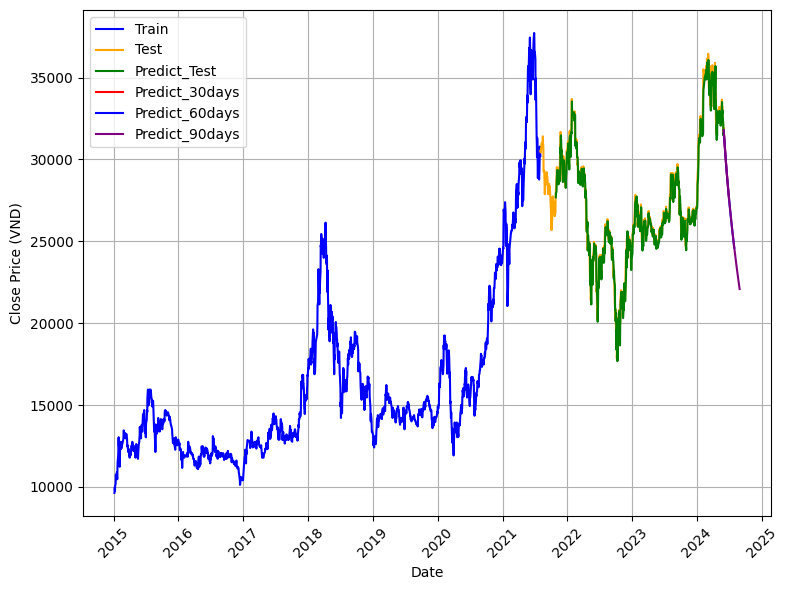

In [6]:
# Trực quan hóa
plt.figure(figsize=(8, 6))

# Vẽ tất cả các giá thực tế
plt.plot(data.index[:train_size], data['Close Price'][:train_size], label='Train', color='blue')

plt.plot(data.index[train_size:], data['Close Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập test
test_data_start = data.index[train_size + n_lookback]
test_data_end = data.index[-1]
plt.plot(data.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')


plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_data = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_data.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Forecast CTG stock prices in the next 90 days:")
print(future_data)

Forecast CTG stock prices in the next 90 days:
                Forecast
Date                    
2024-06-01  31763.552734
2024-06-02  31532.916016
2024-06-03  31358.636719
2024-06-04  31227.501953
2024-06-05  31061.802734
...                  ...
2024-08-25  22402.199219
2024-08-26  22323.091797
2024-08-27  22244.345703
2024-08-28  22165.957031
2024-08-29  22087.925781

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 575.4802762085382
MAPE: 1.5951114442648116 %
MAE: 423.6563622137034


## BID

In [9]:
# Chạy thư viện
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


 # Tải VCB dataset
stock_dataset = pd.read_csv('../../Dataset/BID.csv')
display(stock_dataset)


# Chọn cột Close
data = stock_dataset[['Date','Close']]
data.rename(columns={'Close': 'Close Price'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date',inplace=True)
data.set_index('Date',inplace=True)
y = data['Close Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu trong khoản từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)


# Chia khoảng Train - Test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]


# Khởi tạo Timesteps
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(n_forecast))
# Chạy tới adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=200, batch_size=32,validation_data=(X_test, Y_test),verbose=1)


# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))


# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-05,9101.712891,9172.269531,9101.712891,9101.712891,9101.712891,94080
1,2015-01-06,9031.157227,9383.936523,9031.157227,9313.380859,9313.380859,571418
2,2015-01-07,9313.380859,9595.604492,9242.825195,9595.604492,9595.604492,1177264
3,2015-01-08,9595.604492,9736.716797,9454.493164,9595.604492,9595.604492,1131356
4,2015-01-09,9595.604492,10230.608398,9595.604492,10230.608398,10230.608398,4664782
...,...,...,...,...,...,...,...
2340,2024-05-27,49400.000000,49400.000000,48550.000000,48900.000000,48900.000000,763312
2341,2024-05-28,49000.000000,49200.000000,48600.000000,49100.000000,49100.000000,1230902
2342,2024-05-29,49450.000000,49450.000000,48600.000000,48600.000000,48600.000000,1389049
2343,2024-05-30,48400.000000,48500.000000,47400.000000,47700.000000,47700.000000,2092022


Epoch 1/200


C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3052644285.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Close': 'Close Price'}, inplace=True)
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3052644285.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
C:\Users\ngoct\AppData\Local\Temp\ipykernel_18628\3052644285.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0206 - val_loss: 6.3955e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 3.6633e-04 - val_loss: 5.6183e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 2.9825e-04 - val_loss: 6.0019e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.0829e-04 - val_loss: 5.5684e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 2.6951e-04 - val_loss: 4.5676e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.5056e-04 - val_loss: 4.6386e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 2.3241e-04 - val_loss: 4.9389e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 2.3316e-04 - val_loss: 4.5564e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 2.4430e-04 - val_loss: 4.5440e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 2.0412e-04 - val_loss: 4.8754e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 1.9505e-04 - v

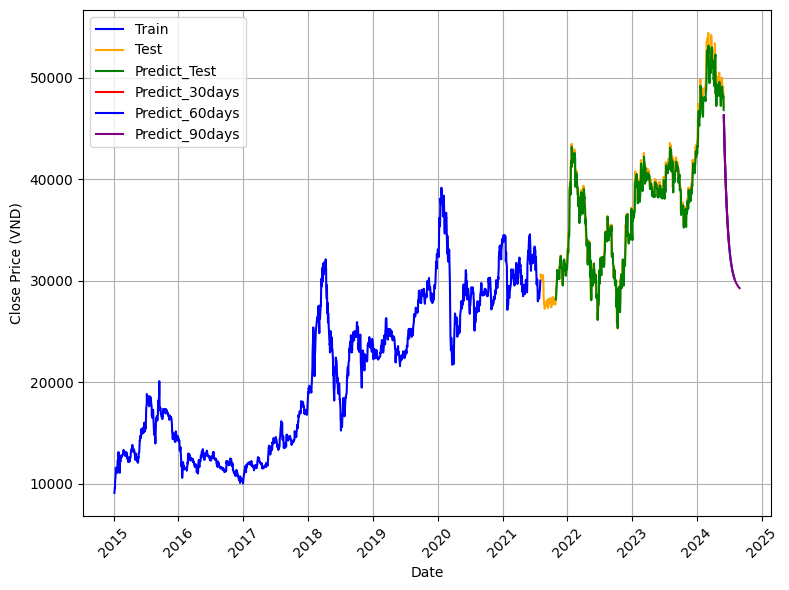

In [10]:
# Trực quan hóa
plt.figure(figsize=(8, 6))

# Vẽ tất cả các giá thực tế
plt.plot(data.index[:train_size], data['Close Price'][:train_size], label='Train', color='blue')

plt.plot(data.index[train_size:], data['Close Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập test
test_data_start = data.index[train_size + n_lookback]
test_data_end = data.index[-1]
plt.plot(data.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=data.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_data = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_data.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Forecast BID stock prices in the next 90 days:")
print(future_data)

Forecast BID stock prices in the next 90 days:
                Forecast
Date                    
2024-06-01  46278.257812
2024-06-02  45492.746094
2024-06-03  44733.710938
2024-06-04  44027.269531
2024-06-05  43355.066406
...                  ...
2024-08-25  29349.564453
2024-08-26  29329.060547
2024-08-27  29309.220703
2024-08-28  29290.019531
2024-08-29  29271.439453

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 922.9850442614354
MAPE: 1.7826733767951006 %
MAE: 683.5617387664985
